# Hamiltonian-based mixflows

Here we develop the code for dealing with continuous data
via mixflows using deterministic Hamiltonian dynamics.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
def lqN(x,rho,u,N,L,eps,lq0,gradlp,momentum='laplace',xi=np.pi/16):
    if N==1: return lq0(x,rho,u)
    w=np.zeros((N,x.shape[1]))
    w[0,:]=lq0(x,rho,u)
    LJ=np.zeros(x.shape[1])
    for n in range(N-1):
        x,rho,u,tlj=flow(x,rho,u,1,L,eps,gradlp,momentum,xi,direction='bwd')
        LJ=LJ+tlj
        w[n+1,:]=lq0(x,rho,u)-LJ
    # end for
    return LogSumExp(w)-np.log(N)
    

def flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',xi=np.pi/16,direction='fwd'):
    if steps==0: return x,rho,u,np.zeros(x.shape[1])
    
    # define laplace functions
    if momentum=='laplace':
        lm = lambda rho : laplace_lm(rho)
        gradlm = lambda rho : laplace_gradlm(rho)
        Fm = lambda rho : laplace_Fm(rho)
        Qm = lambda p : laplace_Qm(p)
        
    ljs=np.zeros(x.shape[1])
    for t in range(steps):
        if direction=='fwd': x,rho,u,tljs=T_Leps_fwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        if direction=='bwd': x,rho,u,tljs=T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        ljs+=tljs
    # end for
    return x,rho,u,ljs
    

def T_Leps_fwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    #print('Starting forwards step')
    #print('Initial x: '+str(x[...,0]))
    #print('Initial rho: '+str(rho[...,0]))
    x,rho=Hamiltonian_update(x,rho,L,eps,gradlp,gradlm)
    u=(u+xi)%1
    lJ=lm(rho)
    rho=Qm((Fm(rho)+prz(x,u))%1)
    lJ=lJ-lm(rho)
    #print('Final x: '+str(x[...,0]))
    #print('Final rho: '+str(rho[...,0]))
    #print()
    return x,rho,u,lJ

def T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    #print('Starting backwards step')
    #print('Initial x: '+str(x[...,0]))
    #print('Initial rho: '+str(rho[...,0]))
    lJ=lm(rho)
    rho=Qm((Fm(rho)-prz(x,u))%1)
    lJ=lJ-lm(rho)
    u=(u-xi)%1
    x,rho=Hamiltonian_update(x,rho,L,-eps,gradlp,gradlm)
    #print('Final x: '+str(x[...,0]))
    #print('Final rho: '+str(rho[...,0]))
    #print()
    return x,rho,u,lJ

def Hamiltonian_update(x,rho,L,eps,gradlp,gradlm):
    #print('Starting Hamiltonian update')
    #print('Initial x: '+str(x))
    for l in range(L):
        rho+=eps*gradlp(x)/2
        x  -=eps*gradlm(rho)
        rho+=eps*gradlp(x)/2
    # end for
    #print('Final x: '+str(x))
    #print()
    return x,rho
    
    
def prz(x,u): return 0.5*np.sin(2*x+u[np.newaxis,:])+0.5
def laplace_lm(rho): return -np.sum(np.abs(rho),axis=0)-np.log(2)
def laplace_gradlm(rho): return -np.sign(rho)
def laplace_Fm(rho): return -0.5*np.sign(rho)*np.exp(-np.sign(rho)*rho)+0.5+0.5*np.sign(rho)
def laplace_Qm(p): return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5))


def LogSumExp(w):
    # LogSumExp trick
    #
    # inputs:
    #    w : (N,d) array, exponents
    #
    # outputs:
    #    w' : (N,d) array, log(sum(exp(w)))
    wmax = np.amax(w,axis=0)
    return wmax + np.log(np.sum(np.exp(w-wmax[np.newaxis,:]),axis=0))

In [58]:
# define the target density and score
def lp(x): return -0.5*np.sum(x**2,axis=0)-0.5*x.shape[0]*np.log(2*np.pi)
def gradlp(x): return -x

# reference distribution
sd0=0.5
mu0=5
gauss_lp = lambda x : -0.5*np.sum((x-mu0)**2,axis=0)/sd0**2-0.5*x.shape[0]*np.log(2*np.pi*sd0**2)
def lq0(x,rho,u): return gauss_lp(x)+laplace_lm(rho)
def randq0(size,M=1): return mu0+sd0*np.random.randn(M,size), np.random.laplace(size=(M,size)),np.random.rand(size)

M=10
d=10000
xi=np.pi/17
x,rho,u=randq0(d,M)

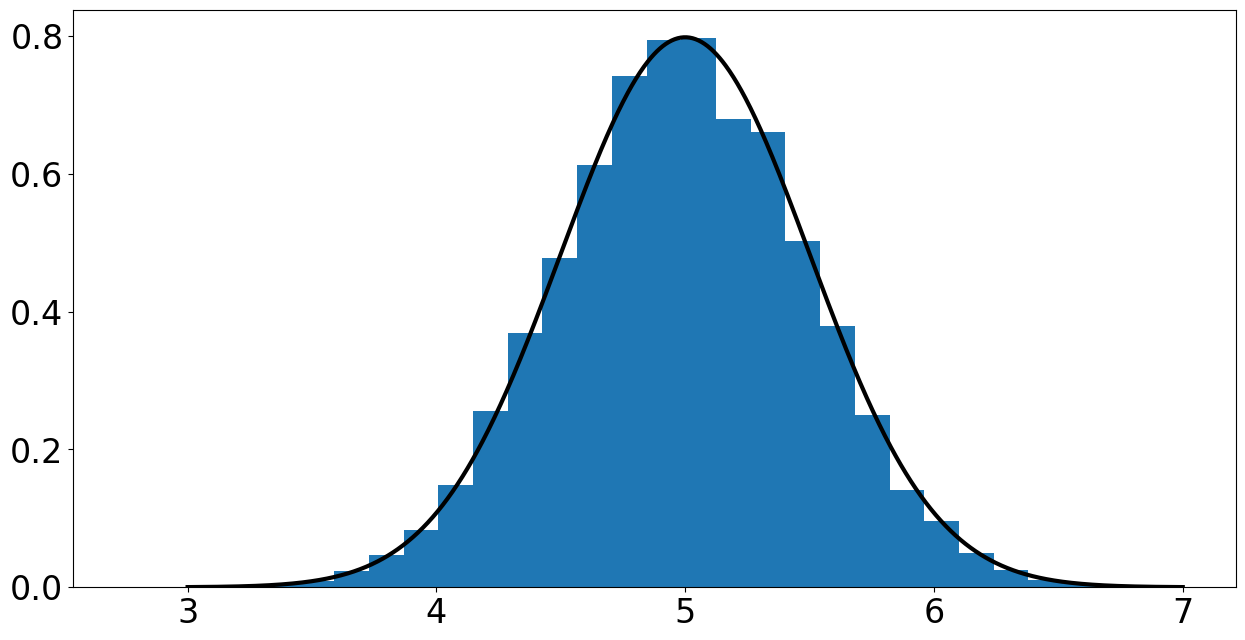

In [59]:
ls=np.linspace(5-4*sd0,5+4*sd0,1000)
plt.hist(x[0,:],bins=30,density=True);
plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')

In [60]:
steps=100
L=50
eps=0.01
tx,trho,tu,tljs=flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',direction='fwd',xi=xi)

In [ ]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(tx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$p(x)$')
plt.legend()

In [ ]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(trho[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(laplace_lm(ls[np.newaxis,:])),lw=3,c='black',label=r'$m(x)$')
plt.legend()

In [ ]:
ls=np.linspace(-4,4,1000)
plt.hist(tu,bins=10,alpha=0.5,density=True);

In [ ]:
ttx,ttrho,ttu,tljs=flow(tx,trho,tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)

In [ ]:
ls=np.linspace(mu0-4*sd0,mu0+4*sd0,1000)
for m in range(M): plt.hist(ttx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')
plt.legend()

In [ ]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(ttrho[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(laplace_lm(ls[np.newaxis,:])),lw=3,c='black',label=r'$m(x)$')
plt.legend()

In [ ]:
ls=np.linspace(-4,4,1000)
plt.hist(ttu,bins=10,alpha=0.5,density=True);

(1000,)


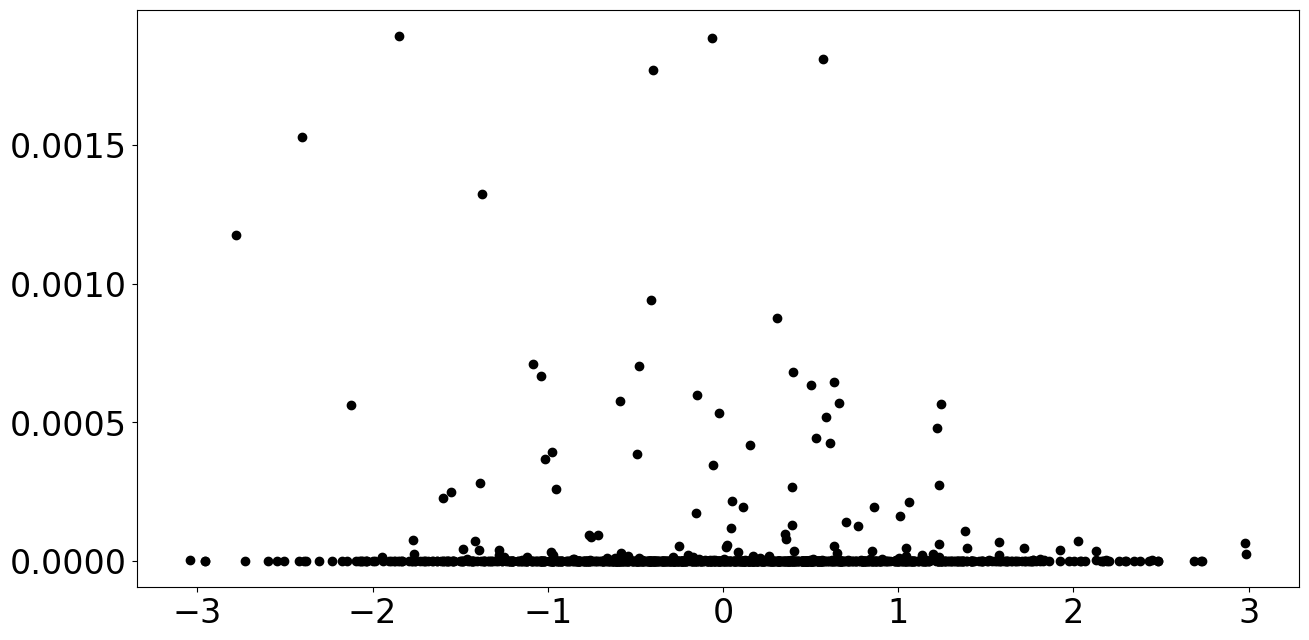

In [41]:
ls=np.linspace(-4,4,1000)
lapprox=lqN(ls[np.newaxis,:],np.zeros((1,ls.shape[0])),0.5*np.ones(ls.shape[0]),steps,L,eps,lq0,gradlp,momentum='laplace',xi=xi)
plt.plot(ls,np.exp(lapprox),'ok')

In [56]:
ls=np.linspace(-4,4,1000)
tttx,tttrho,tttu,tljs=flow(tx[0,:1000].reshape(1,1000),np.random.laplace(size=1000).reshape(1,1000),np.random.rand(1000),100,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)


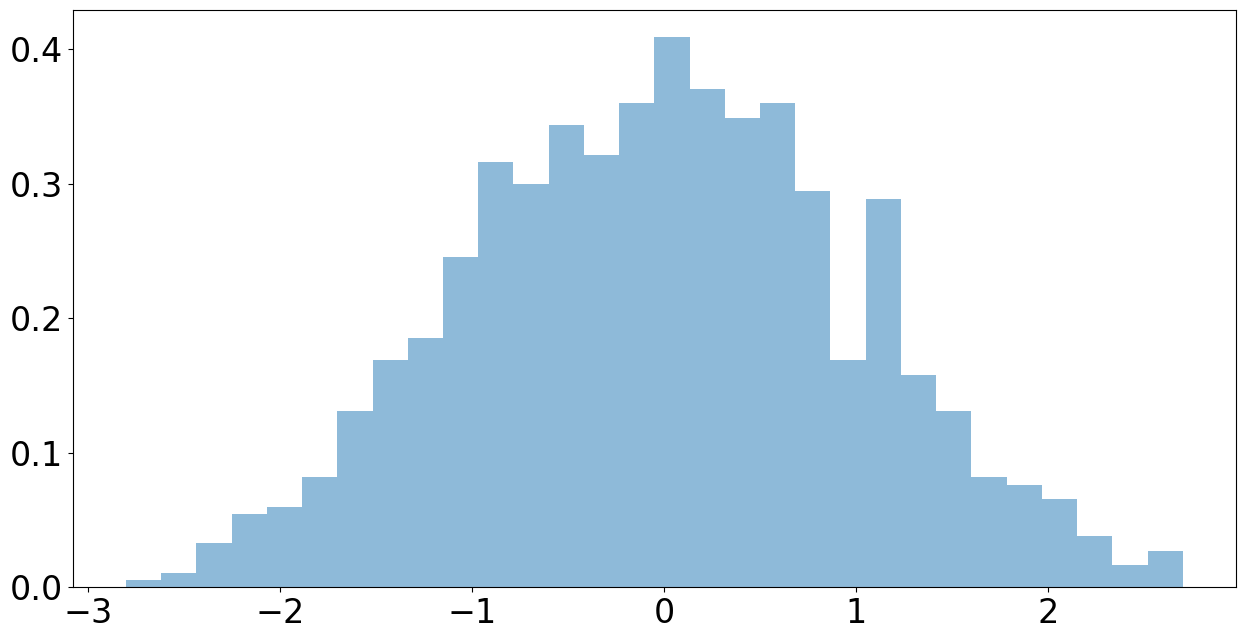

In [57]:
#ls=np.linspace(mu0-4*sd0,mu0+4*sd0,1000)
plt.hist(tttx[0,:],bins=30,alpha=0.5,density=True);
#plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')